In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

(180, 280)


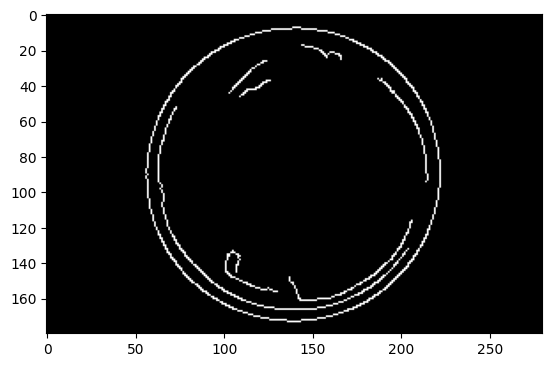

In [13]:
# Load the image
image_path = './images/coin.jpg'
image = cv2.imread(image_path)

# 灰度化
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # (180, 280)

# 高斯滤波
gray_blurred = cv2.GaussianBlur(gray, (15, 15), 0)

# 边缘检测
edges = cv2.Canny(gray_blurred, 30, 100)  # (180, 280)
print(edges.shape)
plt.imshow(edges, cmap='gray')

In [14]:
def compute_gradients(image):
    # Sobel算子
    sobel_x = np.array([[-1, 0, 1], 
                        [-2, 0, 2], 
                        [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[-1, -2, -1], 
                        [0, 0, 0], 
                        [1, 2, 1]], dtype=np.float32)
    
    # 计算x和y方向上的梯度
    grad_x = cv2.filter2D(image, -1, sobel_x)
    grad_y = cv2.filter2D(image, -1, sobel_y)
    
    # 计算梯度幅度和方向
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    angle = np.arctan2(grad_y, grad_x) * (180 / np.pi) % 180
    
    return magnitude, angle

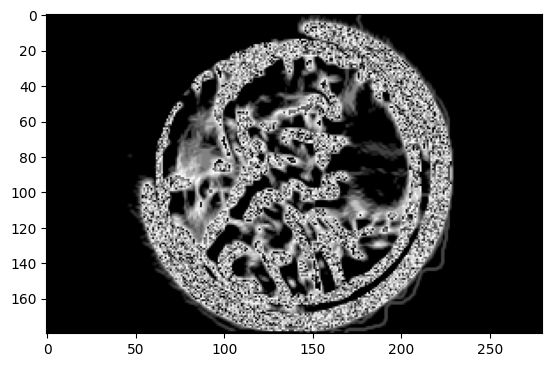

In [56]:
magnitude, angle = compute_gradients(gray_blurred)

plt.imshow(magnitude, cmap='gray')

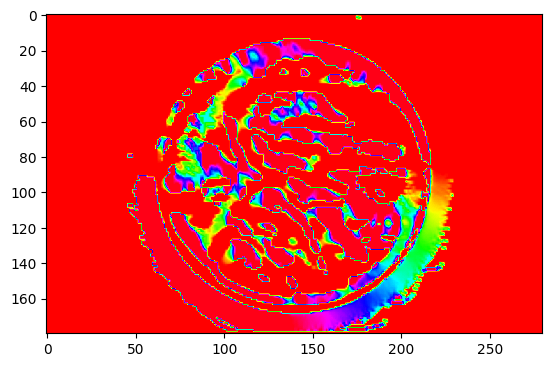

In [18]:
plt.imshow(angle, cmap='hsv')  # 使用HSV颜色空间来更好地表示角度

In [19]:
def non_max_suppression(magnitude, angle):
    """非极大值抑制"""
    M, N = magnitude.shape
    Z = np.zeros((M,N), dtype=np.float32)
    angle[angle < 0] += 180

    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                # 角度0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = magnitude[i, j+1]
                    r = magnitude[i, j-1]
                # 角度45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = magnitude[i+1, j-1]
                    r = magnitude[i-1, j+1]
                # 角度90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = magnitude[i+1, j]
                    r = magnitude[i-1, j]
                # 角度135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = magnitude[i-1, j-1]
                    r = magnitude[i+1, j+1]

                if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                    Z[i,j] = magnitude[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

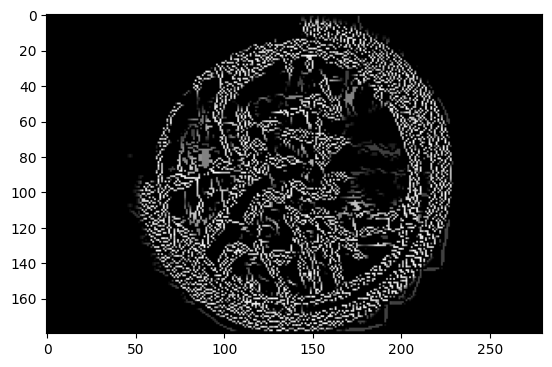

In [21]:
# 非极大值抑制
nms = non_max_suppression(magnitude, angle)

plt.imshow(nms, cmap='gray')

In [50]:
def double_threshold(H, lowThresholdRatio=0.09, highThresholdRatio=0.40):
    """双阈值算法"""
    highThreshold = H.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = H.shape
    res = np.zeros((M,N), dtype=np.float32)
    
    weak = np.float32(25)
    strong = np.float32(255)
    
    strong_i, strong_j = np.where(H >= highThreshold)
    zeros_i, zeros_j = np.where(H < lowThreshold)
    
    weak_i, weak_j = np.where((H <= highThreshold) & (H >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [51]:
def edge_tracking_by_hysteresis(edges, weak, strong=255):
    """通过滞后阈值进行边缘跟踪"""
    M, N = edges.shape
    # 检查每个弱边缘像素周围的8个邻域像素
    for i in range(1, M-1):
        for j in range(1, N-1):
            if edges[i, j] == weak:
                # 如果周围有强边缘，则将弱边缘标记为强边缘
                if ((edges[i+1, j-1] == strong) or (edges[i+1, j] == strong) or (edges[i+1, j+1] == strong)
                    or (edges[i, j-1] == strong) or (edges[i, j+1] == strong)
                    or (edges[i-1, j-1] == strong) or (edges[i-1, j] == strong) or (edges[i-1, j+1] == strong)):
                    edges[i, j] = strong
                else:
                    edges[i, j] = 0
    return edges

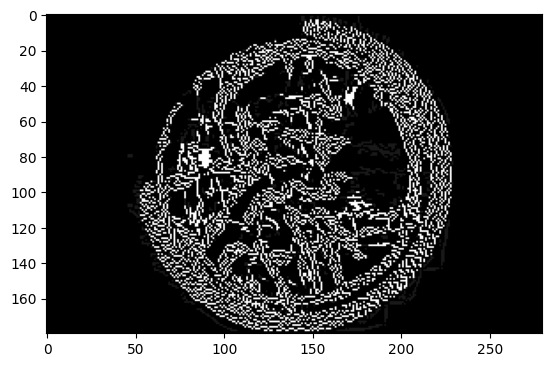

In [52]:
# 双阈值处理
final_edges, weak, strong = double_threshold(nms)

plt.imshow(final_edges, cmap='gray')

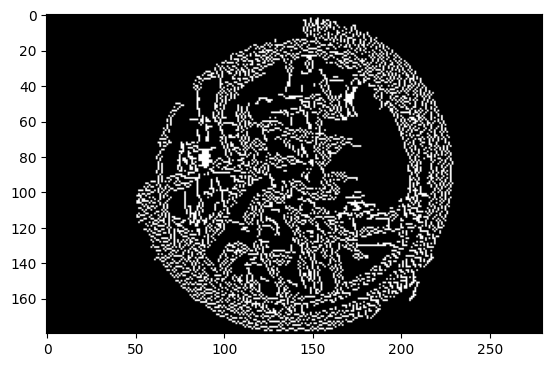

In [53]:
# 应用边缘跟踪
tracked_edges = edge_tracking_by_hysteresis(final_edges, weak, strong)

plt.imshow(tracked_edges, cmap='gray')

100%|██████████| 50400/50400 [00:07<00:00, 6864.58it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


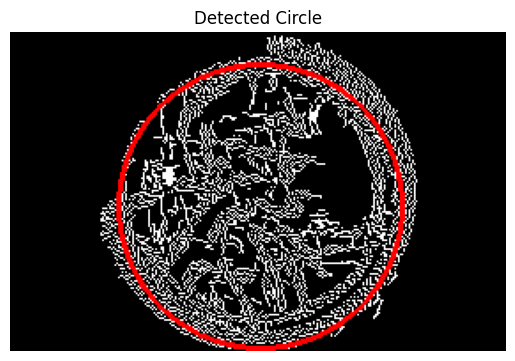

(98, 141, 80)

In [62]:
import math
from tqdm import tqdm

def hough_circles(edges, resolution=1, radius_range=(80, 85)):
    """
    简化的Hough圆变换实现。
    edges: 边缘图像。
    resolution: 累加器的空间分辨率。
    radius_range: 圆半径的可能范围。
    """
    # 初始化累加器
    edges_height, edges_width = edges.shape
    radius_min, radius_max = radius_range
    accumulator = np.zeros((edges_height, edges_width, radius_max-radius_min))
    
    p_par = tqdm(total=edges_width * edges_height)
    # 对每个边缘点进行投票
    for y in range(edges_height):
        for x in range(edges_width):
            p_par.update()
            if edges[y, x] == strong:  # 使用强边缘点
                for radius in range(radius_min, radius_max):
                    for theta in range(0, 360, resolution):  # 为每个角度进行投票
                        a = int(x - radius * math.cos(theta * math.pi / 180))
                        b = int(y - radius * math.sin(theta * math.pi / 180))
                        if a >= 0 and a < edges_width and b >= 0 and b < edges_height:
                            accumulator[b, a, radius-radius_min] += 1
    p_par.close()
    return accumulator

# 应用Hough圆变换
# 注意：考虑到性能和演示的目的，我们这里限定圆的半径在一个较小的范围内
accumulator = hough_circles(tracked_edges, resolution=1, radius_range=(80, 85))

# 简化的可视化，显示累加器的最大投票数对应的半径
# 这里我们只查找最明显的圆，因此只查看累加器中的最大值
accumulated_max = np.amax(accumulator)
coordinates = np.where(accumulator == accumulated_max)
y, x, radius = coordinates[0][0], coordinates[1][0], coordinates[2][0] + 80  # 加上最小半径

# 显示找到的圆
circle_img = np.copy(tracked_edges)
circle_img = np.dstack((circle_img, circle_img, circle_img))
cv2.circle(circle_img, (x, y), radius, (255, 0, 0), 2)

plt.imshow(circle_img)
plt.title('Detected Circle')
plt.axis('off')
plt.show()

y, x, radius

- 使用OpenCV的`HoughCircles`的实现效果：

[[[139.5  89.5  83.5]]]


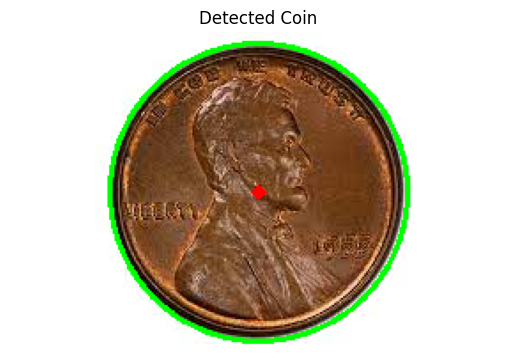

In [57]:
# 霍夫变换
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=50, param1=50, param2=30, minRadius=0, maxRadius=0)
print(circles)

if circles is not None:
    circles = np.uint16(np.around(circles))

    for i in circles[0, :]:
        cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)  # 轮廓
        cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)  # 圆心


image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the result
plt.imshow(image_rgb)
plt.title('Detected Coin')
plt.axis('off')
plt.show()
